<a href="https://colab.research.google.com/github/nileshrathod17/Online-Retail-Customer-Segmentation/blob/main/Customer_Segmentation_for_Online_Retail_store.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Customer Segmentation for Online Retail store**

We endeavour to find the various customer segments using the online retail store's transaction data obtained from UCI Machine Learning Dataset repository. This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.

**The need of customer segmentation:**

The differences in customers' behaviour, demographics, geographies, etc. help in classifying them in groups. Learning about different groups in the customer can help with following:

Target Marketing

Client understanding

Optimal product placement

Searching for new customers

Revenue growth

**Recency-Frequency-Monetary (RFM) model to determine customer value:**

The RFM model is quite useful model in retail customer segmentation where only the data of customer transaction is available. RFM stands for the three dimensions:

Recency – How recently did the customer purchase?

Frequency – How often do they purchase?

Monetary Value – How much do they spend?

A combination of these three attributes can be defined to assign a quantitative value to customers. e.g. A customer who recently bought high value products and transacts regularly is a high value customer.

In [1]:
#Load all the required packages
import pandas as pd
import numpy as np
import datetime
import math
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

# **1. Import Data**

In [2]:
# Mount your drive and read the csv file. Make sure you are using the correct file path
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
file_path = '/content/drive/MyDrive/Colab Notebooks/Online Retail Customer Segmentation/Online Retail.xlsx'
data=pd.read_excel(file_path)

In [5]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


# **2. Exploratory Data Analysis**
**2.1. Top 10 ordering countries**

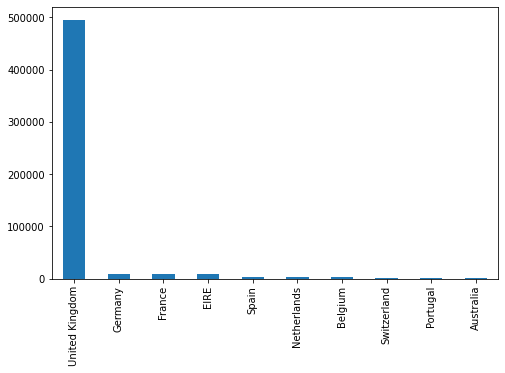

In [6]:
data.Country.value_counts().head(10).plot.bar(figsize=(8,5))

**2.2. Unique customers and order share of top customers**

In [7]:
len(data.CustomerID.unique())

4373

**There are 4373 unique customer records in the dataset**

In [8]:
(data.CustomerID.value_counts()/sum(data.CustomerID.value_counts())*100).head(n=15).cumsum()

17841.0     1.962249
14911.0     3.413228
14096.0     4.673708
12748.0     5.814728
14606.0     6.498553
15311.0     7.110850
14646.0     7.623350
13089.0     8.079807
13263.0     8.492020
14298.0     8.895138
15039.0     9.265809
14156.0     9.614850
18118.0     9.930462
14159.0    10.228376
14796.0    10.514737
Name: CustomerID, dtype: float64

***It is seen that only 10 out of 4000+ customers are responsible for 10% of total orders. These must be the wholesale customers of the retail store***

**2.3. Unique item stock codes and their description**

In [9]:
#Find number of unique items in stock
print(f"Number of unique item stock codes: {len(data.StockCode.unique())}")
print(f"Number of unique item descriptions: {len(data.Description.unique())}")

Number of unique item stock codes: 4070
Number of unique item descriptions: 4224


*The count of unique stock unit ids and their descriptions should have matched but they do not. This implies some stock units might have more than one descriptions. Let us examine the reasons behind this data quality issue:*

In [10]:
#Find out the stock units that have more than one description
dfStockDesc = data.groupby(["StockCode","Description"]).count().reset_index()
dfStockDesc.StockCode.value_counts()[dfStockDesc.StockCode.value_counts()>1].reset_index().head()

,index,StockCode
0,20713,8
1,23084,7
2,21830,6
3,85175,6
4,85172,5


*Now, let us examine how a single unit code has multiple description:*

In [11]:
data[data['StockCode'] == 
         dfStockDesc.StockCode.value_counts()
         [dfStockDesc.StockCode.value_counts()>1].reset_index()
         ['index'][8]]['Description'].unique()

array(['PLEASE ONE PERSON METAL SIGN', 'on cargo order', 'adjustment',
       'check', nan, 'dotcom'], dtype=object)

*We notice that this description is a manually entered field and thus has discrepancies and inconsistencies. However, since the objective of this task is customer segmentation, we avoid exploring and resolving this issue further*

**2.4. Exploring Quantity and Unit Price fields**

In [12]:
data.Quantity.describe()

count    541909.000000
mean          9.552250
std         218.081158
min      -80995.000000
25%           1.000000
50%           3.000000
75%          10.000000
max       80995.000000
Name: Quantity, dtype: float64

*We see 10 goods being sold on an average with a standard deviation of around 200. Also, the minimum quantity includes a negative value, this implies that the dataset includes returned items as well, a common scenario in retail domain*

In [13]:
data.UnitPrice.describe()

count    541909.000000
mean          4.611114
std          96.759853
min      -11062.060000
25%           1.250000
50%           2.080000
75%           4.130000
max       38970.000000
Name: UnitPrice, dtype: float64

*The unit price field echoes the similar observations as Quantity variable*

# **3. Data preprocessing and filtering:**

**1. Filter UK only data:**

We noticed in the exploratory data analysis phase that majority of the transactions belonged to UK, so it makes sense to consider only this country data for maximum impact

In [14]:
data = data[data.Country == "United Kingdom"]

2. Calculate total transaction amount:

Compute the total value of transaction based on quantity sold and per unit price.

In [15]:
data["Amount"] = data["Quantity"] * data["UnitPrice"]

3. Exclude return transactions:

We remove the negative (return goods) transactions before proceeding with the analysis.

In [16]:
data = data[data.Amount >= 0]
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


4. Exclude records without customer IDs:

Since, we concentrate on the task of customer segmentation, we exclude the transaction records that failed to capture the CustomerID

In [17]:
data = data[~data.CustomerID.isnull()]
data.shape

(354345, 9)

# **4. Feature Engineering - Building features for RFM model:**

1. Recency:

We fix a reference date for finding the recent transactions. The reference date would be a day after the most recent transaction date in the dataset. Then we calculate the days difference between the most recent transaction carried out by the customer and this reference date

In [18]:
referenceDate = data['InvoiceDate'].max()
referenceDate += datetime.timedelta(days = 1)

data['Recency'] = (referenceDate - data['InvoiceDate']).astype('timedelta64[D]')
dfCustomerHistory = data.groupby("CustomerID").min().reset_index()[['CustomerID', 'Recency']]
dfCustomerHistory.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Dropping invalid columns in DataFrameGroupBy.min is deprecated. In a future version, a TypeError will be raised. Before calling .min, select only columns which should be valid for the function.
  """


,CustomerID,Recency
0,12346.0,326.0
1,12747.0,2.0
2,12748.0,1.0
3,12749.0,4.0
4,12820.0,3.0


*Distribution of customer recency:*

AttributeError: ignored

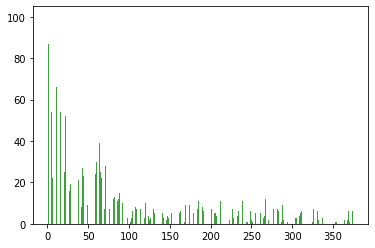

In [19]:
x = dfCustomerHistory.Recency
mu = np.mean(dfCustomerHistory.Recency)
sigma = math.sqrt(np.var(dfCustomerHistory.Recency))
n, bins, patches = plt.hist(x, 1000, facecolor='green', alpha=0.75)
y = mlab.normpdf( bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=2)
plt.xlabel('Recency in days')
plt.ylabel('Number of transactions')
plt.title(r'$\mathrm{Histogram\ of\ sales\ recency}\ $')
plt.grid(True)

*We notice that there have been quite a high number of recent transactions and lesser number of transactions that are older*

**2. Frequency:**

Calculate the frequency of transactions for each customer 

In [20]:
dfCustomerFrequency = data[['CustomerID', 'Amount']].groupby('CustomerID').count().reset_index()
dfCustomerFrequency.rename(columns={'Amount': 'Frequency'}, inplace= True)
dfCustomerHistory = dfCustomerHistory.merge(dfCustomerFrequency, how="outer")
dfCustomerHistory.head()

,CustomerID,Recency,Frequency
0,12346.0,326.0,1
1,12747.0,2.0,103
2,12748.0,1.0,4596
3,12749.0,4.0,199
4,12820.0,3.0,59


**3. Monetary value:**

In [21]:
dfCustomerMV = data[['CustomerID', 'Amount']].groupby('CustomerID').sum().reset_index()
dfCustomerMV.rename(columns={'Amount': 'MonetaryValue'}, inplace= True)
dfCustomerHistory = dfCustomerHistory.merge(dfCustomerMV, how="outer")
#add a small number to monetary value to avoid problems with zeros as we transform to log scale
dfCustomerHistory["MonetaryValue"] = dfCustomerHistory["MonetaryValue"] + 0.001
dfCustomerHistory.head()

,CustomerID,Recency,Frequency,MonetaryValue
0,12346.0,326.0,1,77183.601
1,12747.0,2.0,103,4196.011
2,12748.0,1.0,4596,33719.731
3,12749.0,4.0,199,4090.881
4,12820.0,3.0,59,942.341


# ***5. Feature Scaling:***

Since, all the features like Recency, Frequency and Monetary value are within varying ranges of values, we need to standardize them. In addition, the feature like "Monetary value" can take a very large range of values. So, to standardize all the inputs features, we apply log transform, so that the input to our clustering algorithm is a set of well scaled and transformed features.

In [23]:
#Applying log transformations
dfCustomerHistory['log_Recency'] = dfCustomerHistory["Recency"].apply(math.log)
dfCustomerHistory['log_Frequency'] = dfCustomerHistory["Frequency"].apply(math.log)
dfCustomerHistory['log_MonetaryValue'] = dfCustomerHistory["MonetaryValue"].apply(math.log)

#Preparing matrix for standard scaling transformation
X = dfCustomerHistory[["log_Recency", "log_Frequency", "log_MonetaryValue"]].values
#Standardize the features (mean 0 and std. dev 1)
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

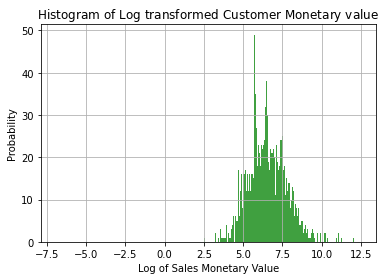

In [24]:
x = dfCustomerHistory.log_MonetaryValue
n, bins, patches = plt.hist(x, 1000, facecolor='green', alpha=0.75)
plt.xlabel('Log of Sales Monetary Value')
plt.ylabel('Probability')
plt.title(r'$\mathrm{Histogram\ of\ Log\ transformed\ Customer\ Monetary\ value}\ $')
plt.grid(True)
plt.show()

In [25]:
dfCustomerHistory.head()

,CustomerID,Recency,Frequency,MonetaryValue,log_Recency,log_Frequency,log_MonetaryValue
0,12346.0,326.0,1,77183.601,5.786897,0.000000,11.253942
1,12747.0,2.0,103,4196.011,0.693147,4.634729,8.341890
2,12748.0,1.0,4596,33719.731,0.000000,8.432942,10.425838
3,12749.0,4.0,199,4090.881,1.386294,5.293305,8.316516
4,12820.0,3.0,59,942.341,1.098612,4.077537,6.848367


# **6. Visualizing the relationship between R, F and M:**

Text(0.5, 0, 'MonetaryValue')

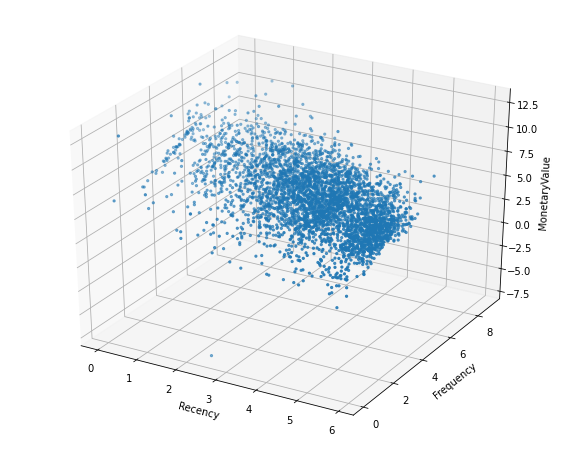

In [26]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

xs =dfCustomerHistory.log_Recency
ys = dfCustomerHistory.log_Frequency
zs = dfCustomerHistory.log_MonetaryValue
ax.scatter(xs, ys, zs, s=5)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('MonetaryValue')

# **Observations:**


1. Customers who recently bought items, are also the ones who buy more freqently and place high value orders
2. Customers who transacted long time ago, also place lower valued orders

3. Customers who buy occasionally, do not tend to buy expensive items

# **7. Customer segmentation through clustering:**

Clustering is an unsupervised classification techinque to understand the groups of classes in the data. We use the K-means clustering algorithm to determine the ideal segments of customers.

Silhouette Analysis - Determine optimum number of segments
Silhouette analysis can be used to study the separation distance between the resulting clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually.

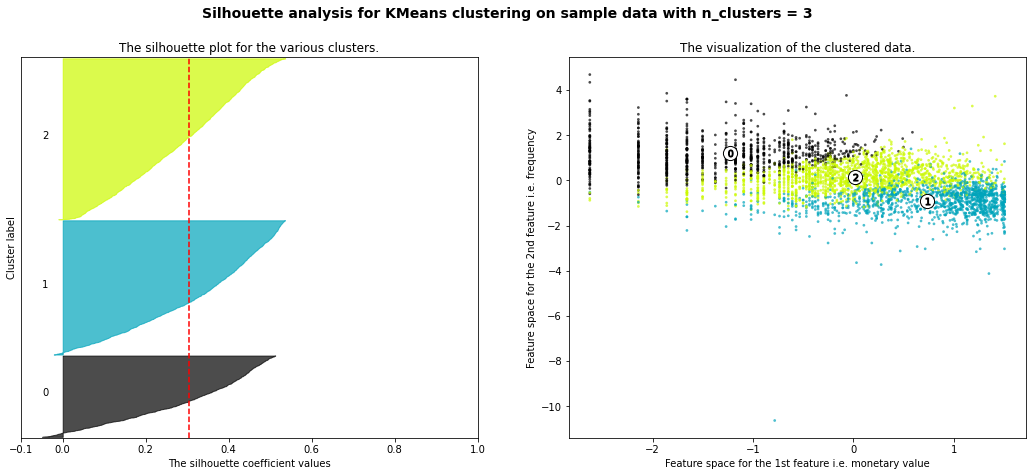

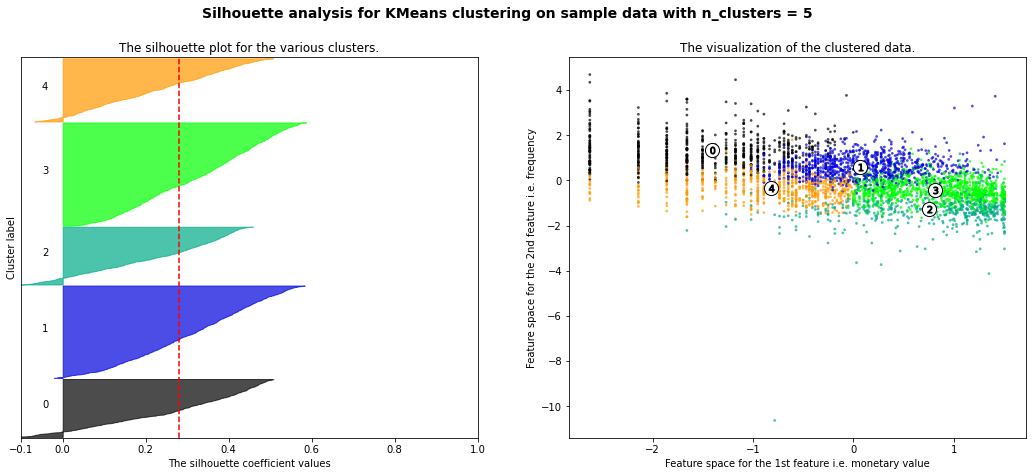

In [29]:
X = X_scaled

cluster_centers = dict()

for n_clusters in range(3,6,2):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    #Train a K-means clustering model with 3/ 5 clusters
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    
    #classify cluster labels based on training data
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)
    cluster_centers.update({n_clusters :{
                                        'cluster_center':clusterer.cluster_centers_,
                                        'silhouette_score':silhouette_avg,
                                        'labels':cluster_labels}
                           })

    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    feature1 = 0
    feature2 = 2
    ax2.scatter(X[:, feature1], X[:, feature2], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    
    centers = clusterer.cluster_centers_
    ax2.scatter(centers[:, feature1], centers[:, feature2], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[feature1], c[feature2], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature i.e. monetary value")
    ax2.set_ylabel("Feature space for the 2nd feature i.e. frequency")
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

# **8.Cluster Analysis & Business Relevance:**

We have obtained a visualization of clusters (customer segments) but in order to reach at any conclusion, we need to inspect the recency, frequency and monetary values associated with each cluster. First, we need to convert back the log transformed values.